# Exemplo de aula: Beer game environment com DQN

## Explicação do Environment

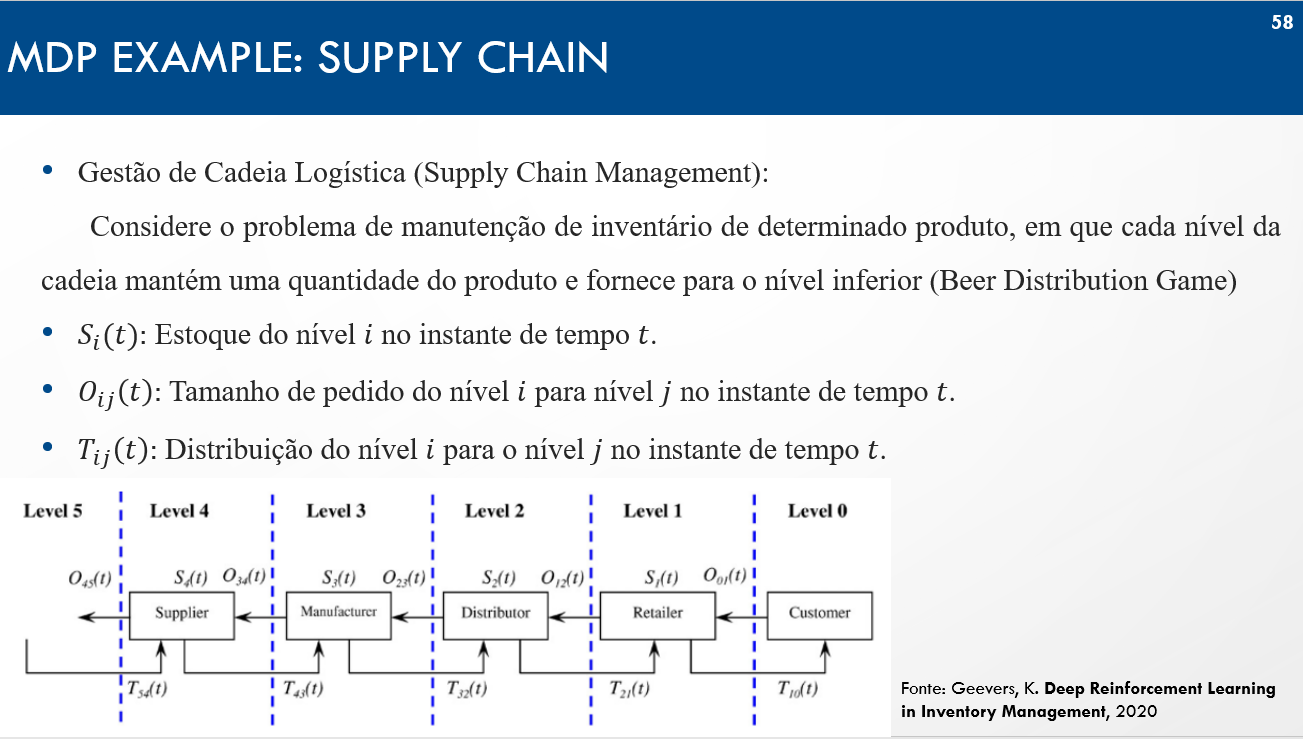

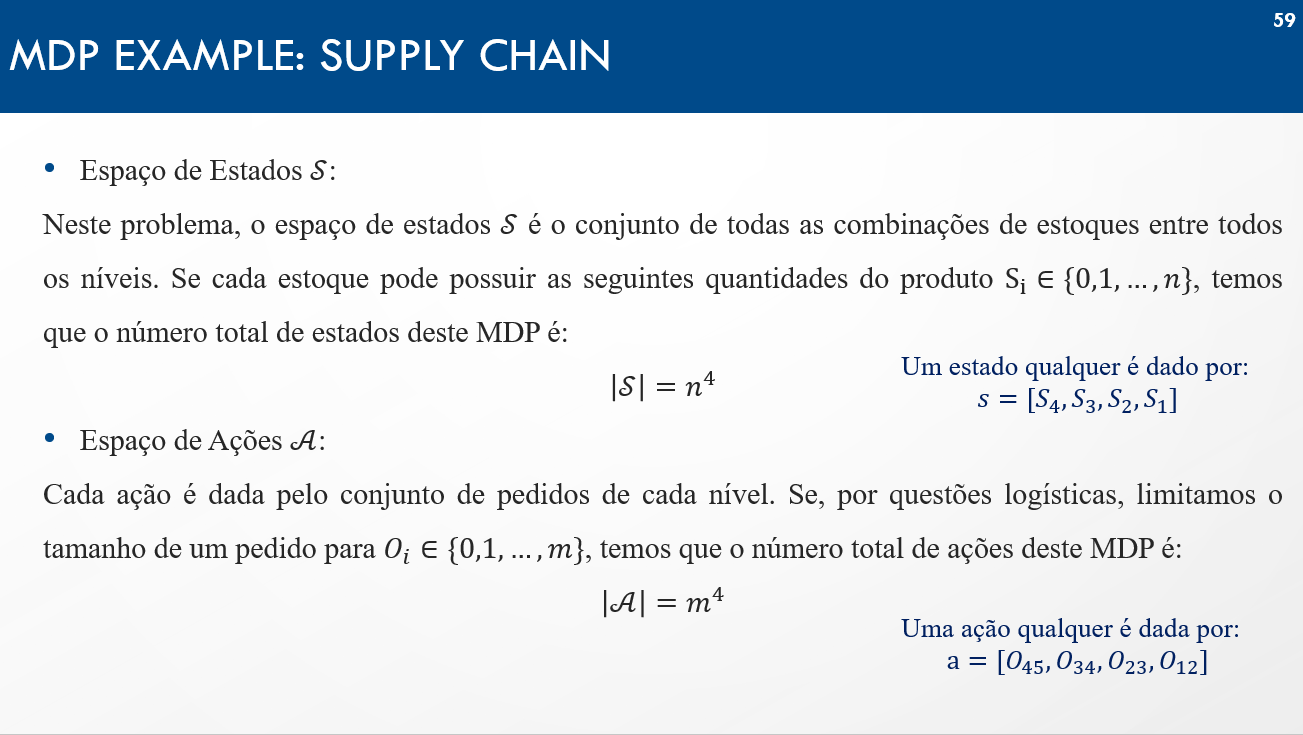

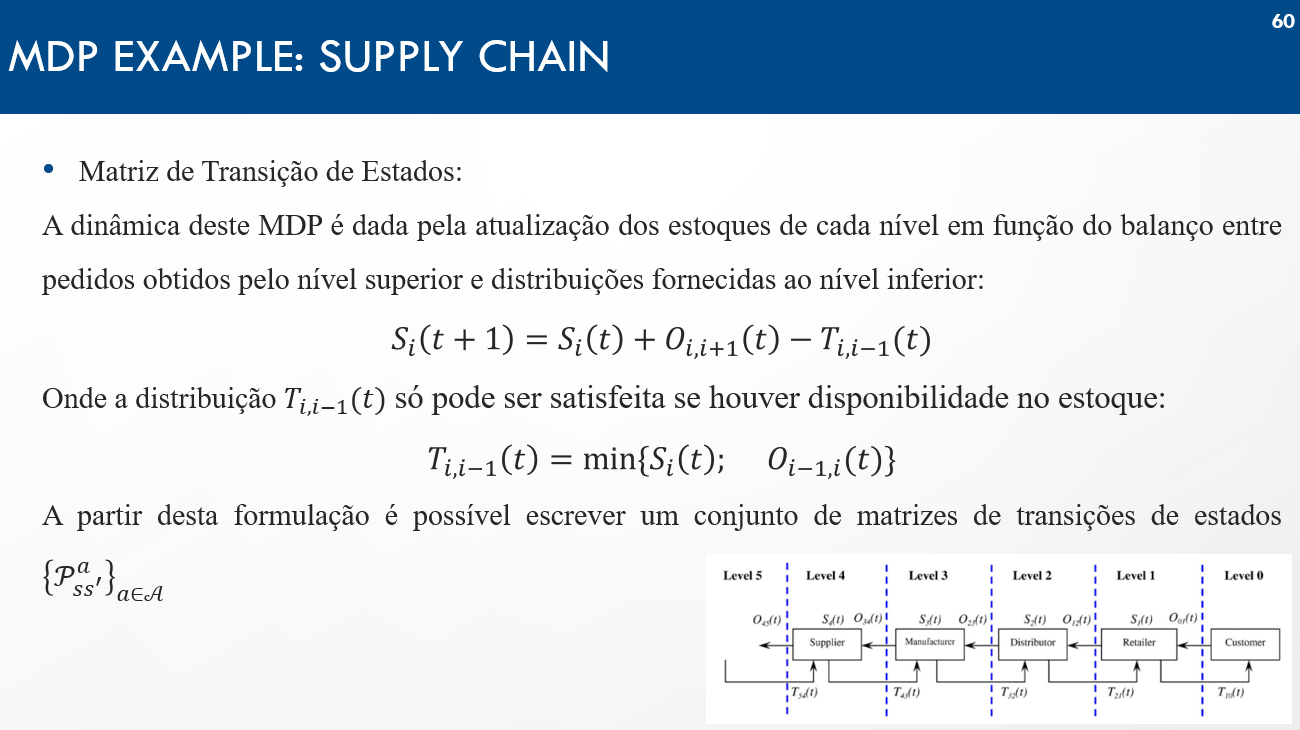

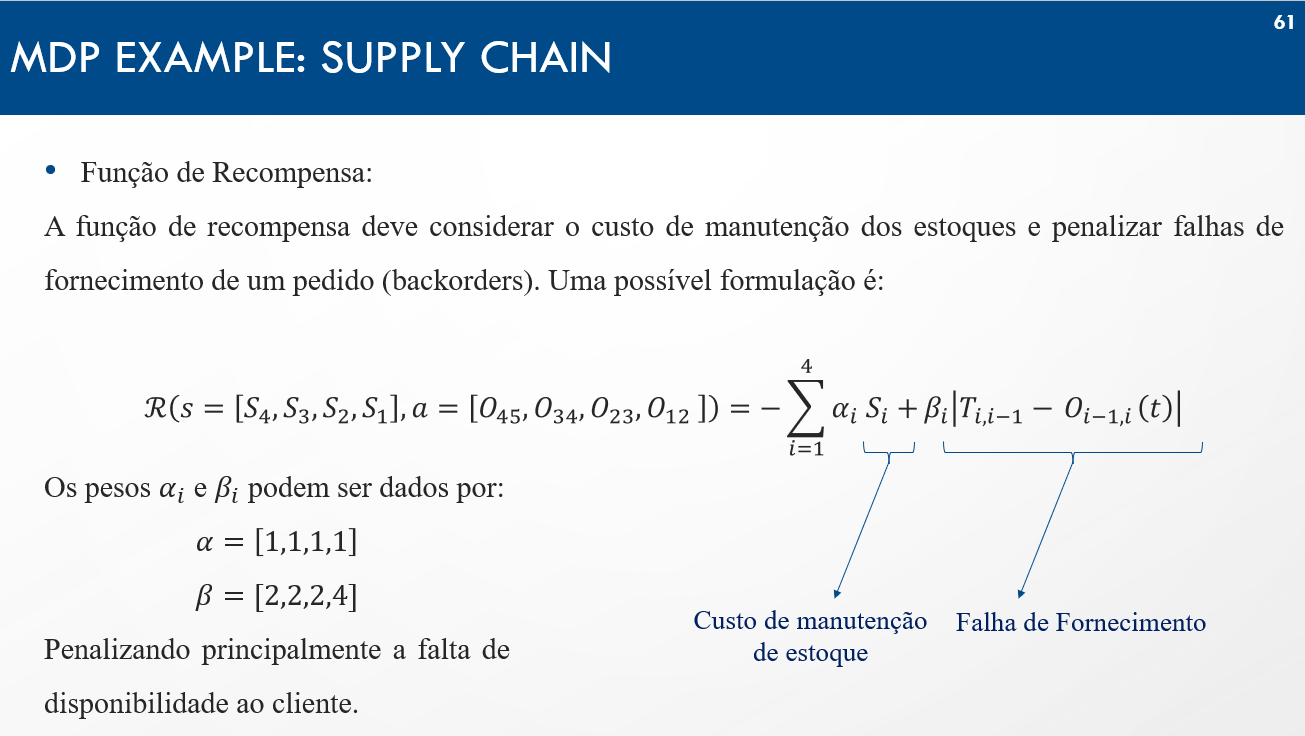

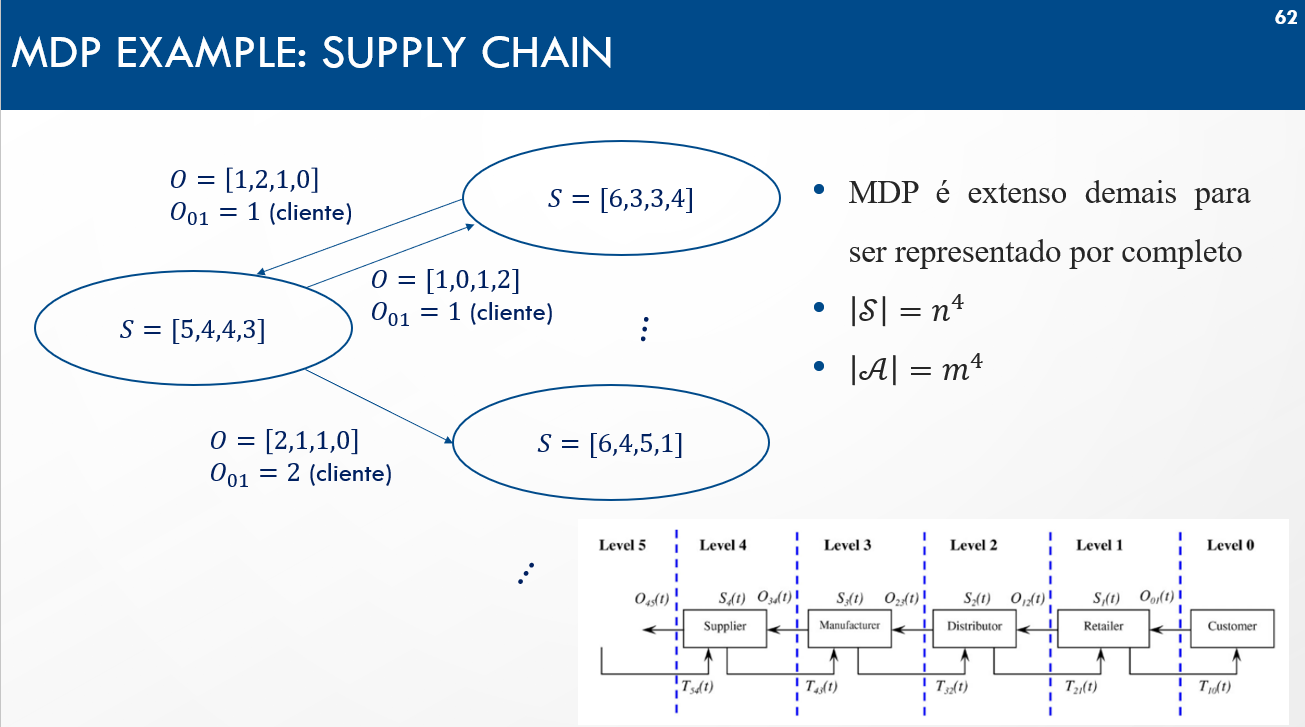

## Imports

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from random import random, randrange, randint, choice
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Lambda


plt.style.use('fivethirtyeight')

## Environment Class

In [ ]:
class BeerGameEnv:
    def __init__(self,max_inventory, max_order, avg_customer_demand = 2, ALPHA = [1,1,1,1], BETA = [2,2,2,4],MAX_TIMESTEP = 180, demand_random = True, random_init=False):

        # Supply Chain Levels
        self.levels = ['Supplier', 'Manufacturer', 'Distributor', 'Retailer']
        self.ALPHA = ALPHA # Inventory Management Cost per product on each level
        self.BETA = BETA # Inventory Lack of Supply Cost per product on each level
        self.avg_customer_demand = avg_customer_demand
        self.MAX_TIMESTEP = MAX_TIMESTEP
        self.demand_random = demand_random
        self.random_init = random_init

        # MDP State Space
        n_levels = len(self.levels)
        inventories = list(range(max_inventory+1))
        aux = [inventories] * n_levels
        state_space = list(itertools.product(*aux))
        self.state_space = [list(e) for e in state_space]

        # MDP Action Space
        orders = list(range(max_order+1))
        aux = [orders] * n_levels
        action_space = list(itertools.product(*aux))
        self.action_space = [list(e) for e in action_space]

        # Initial State
        initial_inventory = int(max_inventory/2)
        self.initial_state = list(initial_inventory*np.ones(len(self.levels)).astype(int))

        # dict int_action_list
        self.int_action_list= dict()
        for i in range(max_order+1):
            for j in range(max_order+1):
                for k in range(max_order+1):
                    for l in range(max_order+1):
                        self.int_action_list[i*(max_order+1)**3+j*(max_order+1)**2+k*(max_order+1)**1+l*(max_order+1)**0] = [i,j,k,l]

    def show(self):
        fig = plt.figure()
        ax = fig.gca()
        ax.bar(self.levels, self.s)
        ax.set_xlabel('Supply Chain Level')
        ax.set_ylabel('Inventory')
    
    def reset(self):
        self.t = 0
        if not self.random_init:
            self.s = self.initial_state.copy()
        else:
            self.s = choice(self.state_space)

        return self.s
    
    def step(self,a):
        # Increment Time-Step
        self.t += 1

        # Customer Demand
        #-------------------------------------------------------
        if self.demand_random:
          gaussian = np.random.normal(self.avg_customer_demand)
          customer_demand = max([0, int(np.round(gaussian))])
        else:
          customer_demand = self.avg_customer_demand

        # Add Customer demand as last level 'order'
        order = self.int_action_list[a]
        order.append(customer_demand)
        #-------------------------------------------------------

        # distributions to lower level (from customer to supplier)
        #-----------------------------------------------------------------------
        # Verify if inventory supports order (minimum inventory)
        T = []
        for i in range(len(self.levels)-1, -1, -1):
            distribution = min([self.s[i], order[i+1]])
            T.append(distribution)
        T.reverse()

        # Verify if order causes inventory to exceed maximum (maximum inventory)
        for i in range(len(self.levels)-2, -1, -1):
            if (self.s[i+1] + T[i] - T[i+1] > 9):
                dif = (self.s[i+1] + T[i] - T[i+1]) - 9
                T[i] = T[i] - dif
        #-----------------------------------------------------------------------
        

        # Reward Function
        r = 0
        for i in range(1,len(self.levels)):
            r -= self.ALPHA[i]*self.s[i] + self.BETA[i]*max([0,  order[i+1] - T[i]])


        # Next State
        S_next = self.s.copy()
        S_next[0] = min([S_next[0] + order[0] - T[0],  9])
        for i in range(1,len(self.levels)):
            S_next[i] = min([self.s[i] + T[i-1] - T[i], 9])
        
        # Update Current State
        self.s = S_next.copy()

        # Check end of episode
        done = False
        if (self.t == self.MAX_TIMESTEP):
            done = True
        
        return S_next, r, done



## Funções Auxiliares

In [ ]:
# Plot the average rewards of each epoch during training
def plot_avg_rewards(avg_rewards_list, agent_type):
  fig = plt.figure()
  ax = fig.gca()
  ax.plot(avg_rewards_list, lw=1.5)
  fig.suptitle(agent_type + ' on Beer Game Environment', fontsize=16)
  ax.set_xlabel('Episode', fontsize=14)
  ax.set_ylabel('Average Rewards', fontsize=14)
  plt.show()

# Print the action space of the environment
def print_states_actions(env):
  print('Espaço de Estados ' + str(env.state_space))
  print('|S| = ' + str(len(env.state_space)))
  print('Espaço de Ações: ' + str(env.action_space))
  print('|A| = ' + str(len(env.action_space)))

##DQN 

### Network class 

In [ ]:
class DQNetwork:
    def __init__(self,
                 name,
                 actions,
                 input_shape,
                 learning_rate=0.00025,
                 discount_factor=0.99,
                 minibatch_size=32,
                 dropout_prob=0.1):
        
        # Parameters
        self.name = name
        self.actions = actions  # Size of the network output
        self.discount_factor = discount_factor  # Discount factor of the MDP
        self.minibatch_size = minibatch_size  # Size of the training batches
        self.learning_rate = learning_rate  # Learning rate
        self.dropout_prob = dropout_prob  # Probability of dropout
        

                
        S = keras.Input(name='S', shape=input_shape, dtype='uint8')

        hidden_layer1 = Dense(units=50, activation='relu')(S)
        hidden_layer2 = Dense(units=200, activation='relu')(hidden_layer1)

        # Output Layer
        Q = keras.layers.Dense(units=actions,
                               activation='linear',
                               kernel_initializer='zeros',
                               name='Q')(hidden_layer2)
        self.model = keras.Model(inputs=S, outputs=Q)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss="mean_squared_error")
    
    
    def train(self, batch, DQN_target):
        """
        Generates inputs and targets from the given batch, trains the model on
        them.
        
        batch: iterable of dictionaries with keys 'state', 'action',
        'next_state', 'reward', 'final'
        DQN_target: a target model to generate targets
        """
        
        States = [datapoint['state'] for datapoint in batch]
        Next_States = [datapoint['next_state'] for datapoint in batch]
        Q_train = []
        
        # Apply DQN and DQN_target to every datapoint simultaneously to reduce computation time
        Current_States_Q_Values = self.model(tf.concat(States,axis=0)).numpy()   # Current States
        Next_States_Q_Values = DQN_target(tf.concat(Next_States,axis=0)).numpy() # Next States
        Next_States_Max_Q_Values = np.max(Next_States_Q_Values,axis=1)           # Max Q Values
        
        # Build Q_train targets
        for i in range(0,len(batch)):
            datapoint = batch[i]
            # The error must be 0 on all actions except the one taken
            y = list(Current_States_Q_Values[i,:])
            if datapoint['final']:
                y[datapoint['action']] = datapoint['reward']
            else:
                y[datapoint['action']] = datapoint['reward'] + \
                                         self.discount_factor * Next_States_Max_Q_Values[i]
            Q_train.append(y)
            

        # Prepare inputs and targets
        S_train = np.asarray(States).squeeze()
        Q_train = np.asarray(Q_train).squeeze()
        
        
        # Train the model for one epoch
        self.model.train_on_batch(S_train,
                                  Q_train)
        
    
    
    def predict(self, state):
        """
        Feeds state to the model, returns predicted Q-values.
        state: a numpy.array with same shape as the network's input
        
        :return: numpy.array with predicted Q-values
        """
        return self.model.predict(state, batch_size=1)
    
    
    def save(self):
        """
        Saves the model weights to disk.
        :param filename: file to which save the weights (must end with ".h5")
        :param append: suffix to append after "model" in the default filename
            if no filename is given
        """
        self.model.save(self.name)

### DQN Agent

In [ ]:
class DQAgent:
    def __init__(self,
                 actions,
                 network_input_shape=(4),
                 replay_memory_size=1024,
                 minibatch_size=32,
                 learning_rate=0.00025,
                 discount_factor=0.99,
                 dropout_prob=0.1,
                 epsilon=1,
                 epsilon_decrease_rate=9e-7,
                 min_epsilon=0.1):
        
        # Parameters
        self.actions = actions  # Size of the discrete action space
        self.network_input_shape = network_input_shape  # Shape of the DQN input
        self.replay_memory_size = replay_memory_size  # Size of replay memory
        self.minibatch_size = minibatch_size  # Size of a DQN minibatch
        self.learning_rate = learning_rate  # Learning rate for the DQN
        self.discount_factor = discount_factor  # Discount factor of the MDP
        self.dropout_prob = dropout_prob  # Dropout probability of the DQN
        self.epsilon = epsilon  # Probability of taking a random action
        self.epsilon_decrease_rate = epsilon_decrease_rate  # See update_epsilon
        self.min_epsilon = min_epsilon  # Minimum value for epsilon
        
        # Replay memory
        self.experience_replay = []
        self.training_count = 0
        
        # Instantiate the deep Q-networks
        # Main DQN
        self.DQN = DQNetwork(
            'DQN',
            self.actions,
            self.network_input_shape,
            learning_rate=self.learning_rate,
            discount_factor=self.discount_factor,
            minibatch_size=self.minibatch_size,
            dropout_prob=self.dropout_prob)
        
        # Target DQN used to generate targets
        self.DQN_target = keras.models.clone_model(self.DQN.model)
        self.DQN_target.trainable = False  # exclude from trainable weights
        
    
    
    def get_action(self, state, training=True, random_action=False):
        """
        Polls DQN for Q-values. Returns argmax(Q) with probability 1-epsilon
        during training, 0 during testing.
        
        state: a state that can be passed as input to DQN
        training: whether to use the current epsilon or return greedy action
        random_action: whether to sample a random action regardless of parameters
        
        :return: the index of (action associated to) the highest Q-value 
        """
        is_random = (random() < self.epsilon) if training else False
        if random_action or is_random:
            return randint(0, self.actions - 1)
        else:
            q_values = self.DQN.predict(state)
            return np.argmax(q_values)
    
    
    def get_max_q(self, state):
        """
        Returns the maximum Q value predicted on the given state.
        :param state: a state that can be passed as input to DQN
        :return: an action index corresponding to the maximum Q-value in the 
            given state
        """
        q_values = self.DQN.predict(state)
        idxs = np.argwhere(q_values == np.max(q_values)).ravel()
        return np.random.choice(idxs)
    
    
    def get_random_state(self):
        """
        Samples a random state from the replay memory.
        :return: the sampled state
        """
        return self.experience_replay[randrange(0, len(self.experience_replay))]['state']
    
    
    def add_experience(self, state, action, reward, next_state, final):
        """
        Add a SARS' tuple to the experience replay.
        :param state: current state
        :param action: action index
        :param reward: reward associated to the transition
        :param next_state: next state
        :param final: whether the state is absorbing
        """
        # Remove older transitions if the replay memory is full
        if len(self.experience_replay) >= self.replay_memory_size:
            self.experience_replay.pop(0)
        # Add a tuple (source, action, reward, dest, final) to replay memory
        self.experience_replay.append({'state': state,
                                       'action': action,
                                       'reward': reward,
                                       'next_state': next_state,
                                       'final': final})
    
    
    def sample_batch(self):
        """
        Samples self.minibatch_size random transitions from the replay memory
        and returns them as a batch.
        :return: a batch of SARS' tuples
        """
        batch = []
        for i in range(self.minibatch_size):
            batch.append(self.experience_replay[randrange(0, len(self.experience_replay))])
        return np.asarray(batch)
    
    
    def train(self):
        """
        Trains the DQN on a minibatch of transitions.
        """
        self.training_count += 1
#        print ('Training session #%d - epsilon: %f' % \
#              (self.training_count, self.epsilon))
        batch = self.sample_batch()
        
        self.DQN.train(batch, self.DQN_target)  # Train the DQN
    
    
    def update_epsilon(self):
        """
        Decreases the probability of picking a random action, to improve
        exploitation.
        """
        if self.epsilon - self.epsilon_decrease_rate > self.min_epsilon:
            self.epsilon -= self.epsilon_decrease_rate
        else:
            self.epsilon = self.min_epsilon
    
    
    def sync_target_network(self):
        """
        Updates the target DQN with the current weights of the main DQN.
        """
        print('Synchronizing Target Network')
        self.DQN_target.set_weights(self.DQN.model.get_weights())
    
    
    def save_networks(self):
        """
        Saves DQN and DQN_target.
        """
        self.DQN.save()
        self.DQN_target.save()

## Loop de treino para demanda constante

In [ ]:
#Hiperparâmetros

MAX_EPISODES = 75                     # Maximum Number of Episodes to be simulated
MAX_TIMESTEPS_PER_EPISODE = np.inf     # Maximum number of timsteps in a single episode
EXPERIENCE_REPLAY_SIZE = 2e4         # Maximum Size of Experience Replay Memory
EXPERIENCE_START_SIZE = 2e2           # Minimum number of random transitions to store before training
MINIBATCH_SIZE = 32                    # Size of minibatch sampled during training
TARGET_NETWORK_UPDATE_FREQ = 200       # Rate at which DQN_target is synchronized with DQN
LEARNING_RATE = 0.00025                # Learning rate used during training
DISCOUNT_FACTOR = 0.3                 # MDP discount factor gamma
DROPOUT_PROB = 0.1                     # Dropout rate for the DQN
INITIAL_EPSILON = 1                    # Initial value of epsilon for epsilon-greedy policy
EPSILON_DECREASE_RATE = 8e-5          # Epsilon decrease rate
MIN_EPSILON = 0.0                      # Minimum epsilon value to guarantee minimum exploration later

Espaço de Estados [[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 2], [0, 0, 0, 3], [0, 0, 0, 4], [0, 0, 0, 5], [0, 0, 1, 0], [0, 0, 1, 1], [0, 0, 1, 2], [0, 0, 1, 3], [0, 0, 1, 4], [0, 0, 1, 5], [0, 0, 2, 0], [0, 0, 2, 1], [0, 0, 2, 2], [0, 0, 2, 3], [0, 0, 2, 4], [0, 0, 2, 5], [0, 0, 3, 0], [0, 0, 3, 1], [0, 0, 3, 2], [0, 0, 3, 3], [0, 0, 3, 4], [0, 0, 3, 5], [0, 0, 4, 0], [0, 0, 4, 1], [0, 0, 4, 2], [0, 0, 4, 3], [0, 0, 4, 4], [0, 0, 4, 5], [0, 0, 5, 0], [0, 0, 5, 1], [0, 0, 5, 2], [0, 0, 5, 3], [0, 0, 5, 4], [0, 0, 5, 5], [0, 1, 0, 0], [0, 1, 0, 1], [0, 1, 0, 2], [0, 1, 0, 3], [0, 1, 0, 4], [0, 1, 0, 5], [0, 1, 1, 0], [0, 1, 1, 1], [0, 1, 1, 2], [0, 1, 1, 3], [0, 1, 1, 4], [0, 1, 1, 5], [0, 1, 2, 0], [0, 1, 2, 1], [0, 1, 2, 2], [0, 1, 2, 3], [0, 1, 2, 4], [0, 1, 2, 5], [0, 1, 3, 0], [0, 1, 3, 1], [0, 1, 3, 2], [0, 1, 3, 3], [0, 1, 3, 4], [0, 1, 3, 5], [0, 1, 4, 0], [0, 1, 4, 1], [0, 1, 4, 2], [0, 1, 4, 3], [0, 1, 4, 4], [0, 1, 4, 5], [0, 1, 5, 0], [0, 1, 5, 1], [0, 1, 5, 2], [0, 1, 5, 3], [

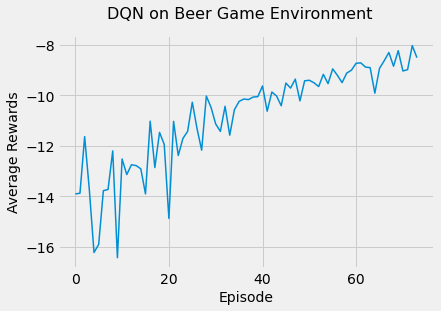

In [ ]:
#Start env
env = BeerGameEnv(max_inventory = 5, max_order = 3, avg_customer_demand = 2, demand_random = False, random_init= True)
print_states_actions(env)


episode = 1
total_timesteps = 0
rewards_list = []


# Create Agent
DQA = DQAgent(len(env.action_space),
              network_input_shape=(4),
              replay_memory_size=EXPERIENCE_REPLAY_SIZE,
              minibatch_size=MINIBATCH_SIZE,
              learning_rate=LEARNING_RATE,
              discount_factor=DISCOUNT_FACTOR,
              dropout_prob=DROPOUT_PROB,
              epsilon=INITIAL_EPSILON,
              epsilon_decrease_rate=EPSILON_DECREASE_RATE,
              min_epsilon=MIN_EPSILON)




# Main loop
while episode < MAX_EPISODES:
    # Start episode

    print('-------------------------------------------------')
    print('Episode: ' + str(episode))
    sum_rewards = 0
    
    # Initialize first state
    current_state = env.reset()
    
    # Main episode loop
    t = 0
    total_timesteps += 1
    while t < MAX_TIMESTEPS_PER_EPISODE:

        
        # Select an action using the DQA
        action = DQA.get_action(np.asarray([current_state]))

        # Observe reward and next state
        (next_state, reward, done) = env.step(action)
        total_timesteps += 1

        # Store transition in replay memory
        DQA.add_experience(np.asarray([current_state]),
                           action,
                           reward,
                           np.asarray([next_state]),
                           done)
        
        # Train the agent
        if len(DQA.experience_replay) >= EXPERIENCE_START_SIZE:
            DQA.train()
            # Every C DQN updates, update DQN_target
            if DQA.training_count % TARGET_NETWORK_UPDATE_FREQ == 0 and DQA.training_count >= TARGET_NETWORK_UPDATE_FREQ:
                DQA.sync_target_network()
        
        # Linear epsilon annealing
        if len(DQA.experience_replay) >= EXPERIENCE_START_SIZE:
            DQA.update_epsilon()

        # Update the current state and score
        current_state = next_state
        sum_rewards += reward

        # Check end of episode
        if done:
            rewards_list.append(sum_rewards)
            print("Length: %d; Score: %d" % (t + 1, score))
            print("Epsilon = " + str(DQA.epsilon))
            print("Total Timesteps = " + str(total_timesteps))
            break
        
        # Increment Episode Timestep
        t += 1
    

    # Increment Episode counter
    episode += 1

plot_avg_rewards(np.array(rewards_list)/180, "DQN")   

## Loop de treino para demanda variável

In [ ]:
#Hiperparâmetros

MAX_EPISODES = 150                     # Maximum Number of Episodes to be simulated
MAX_TIMESTEPS_PER_EPISODE = np.inf     # Maximum number of timsteps in a single episode
EXPERIENCE_REPLAY_SIZE = 2e4         # Maximum Size of Experience Replay Memory
EXPERIENCE_START_SIZE = 2e2           # Minimum number of random transitions to store before training
MINIBATCH_SIZE = 32                    # Size of minibatch sampled during training
TARGET_NETWORK_UPDATE_FREQ = 200       # Rate at which DQN_target is synchronized with DQN
LEARNING_RATE = 0.00025                # Learning rate used during training
DISCOUNT_FACTOR = 0.3                 # MDP discount factor gamma
DROPOUT_PROB = 0.1                     # Dropout rate for the DQN
INITIAL_EPSILON = 1                    # Initial value of epsilon for epsilon-greedy policy
EPSILON_DECREASE_RATE = 4e-5          # Epsilon decrease rate
MIN_EPSILON = 0.0                      # Minimum epsilon value to guarantee minimum exploration later



Espaço de Estados [[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 2], [0, 0, 0, 3], [0, 0, 0, 4], [0, 0, 1, 0], [0, 0, 1, 1], [0, 0, 1, 2], [0, 0, 1, 3], [0, 0, 1, 4], [0, 0, 2, 0], [0, 0, 2, 1], [0, 0, 2, 2], [0, 0, 2, 3], [0, 0, 2, 4], [0, 0, 3, 0], [0, 0, 3, 1], [0, 0, 3, 2], [0, 0, 3, 3], [0, 0, 3, 4], [0, 0, 4, 0], [0, 0, 4, 1], [0, 0, 4, 2], [0, 0, 4, 3], [0, 0, 4, 4], [0, 1, 0, 0], [0, 1, 0, 1], [0, 1, 0, 2], [0, 1, 0, 3], [0, 1, 0, 4], [0, 1, 1, 0], [0, 1, 1, 1], [0, 1, 1, 2], [0, 1, 1, 3], [0, 1, 1, 4], [0, 1, 2, 0], [0, 1, 2, 1], [0, 1, 2, 2], [0, 1, 2, 3], [0, 1, 2, 4], [0, 1, 3, 0], [0, 1, 3, 1], [0, 1, 3, 2], [0, 1, 3, 3], [0, 1, 3, 4], [0, 1, 4, 0], [0, 1, 4, 1], [0, 1, 4, 2], [0, 1, 4, 3], [0, 1, 4, 4], [0, 2, 0, 0], [0, 2, 0, 1], [0, 2, 0, 2], [0, 2, 0, 3], [0, 2, 0, 4], [0, 2, 1, 0], [0, 2, 1, 1], [0, 2, 1, 2], [0, 2, 1, 3], [0, 2, 1, 4], [0, 2, 2, 0], [0, 2, 2, 1], [0, 2, 2, 2], [0, 2, 2, 3], [0, 2, 2, 4], [0, 2, 3, 0], [0, 2, 3, 1], [0, 2, 3, 2], [0, 2, 3, 3], [0, 2, 3, 4], [

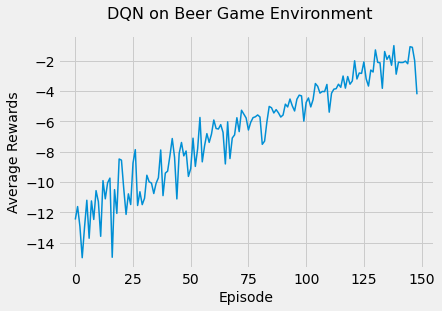

In [ ]:
#Start env
env = BeerGameEnv(max_inventory = 4, max_order = 2, avg_customer_demand = 1, demand_random = True, random_init= True)
print_states_actions(env)


episode = 1
total_timesteps = 0
rewards_list = []


# Create Agent
DQA = DQAgent(len(env.action_space),
              network_input_shape=(4),
              replay_memory_size=EXPERIENCE_REPLAY_SIZE,
              minibatch_size=MINIBATCH_SIZE,
              learning_rate=LEARNING_RATE,
              discount_factor=DISCOUNT_FACTOR,
              dropout_prob=DROPOUT_PROB,
              epsilon=INITIAL_EPSILON,
              epsilon_decrease_rate=EPSILON_DECREASE_RATE,
              min_epsilon=MIN_EPSILON)




# Main loop
while episode < MAX_EPISODES:
    # Start episode

    print('-------------------------------------------------')
    print('Episode: ' + str(episode))
    sum_rewards = 0
    
    # Initialize first state
    current_state = env.reset()
    
    # Main episode loop
    t = 0
    total_timesteps += 1
    while t < MAX_TIMESTEPS_PER_EPISODE:

        
        # Select an action using the DQA
        action = DQA.get_action(np.asarray([current_state]))

        # Observe reward and next state
        (next_state, reward, done) = env.step(action)
        total_timesteps += 1

        # Store transition in replay memory
        DQA.add_experience(np.asarray([current_state]),
                           action,
                           reward,
                           np.asarray([next_state]),
                           done)
        
        # Train the agent
        if len(DQA.experience_replay) >= EXPERIENCE_START_SIZE:
            DQA.train()
            # Every C DQN updates, update DQN_target
            if DQA.training_count % TARGET_NETWORK_UPDATE_FREQ == 0 and DQA.training_count >= TARGET_NETWORK_UPDATE_FREQ:
                DQA.sync_target_network()
        
        # Linear epsilon annealing
        if len(DQA.experience_replay) >= EXPERIENCE_START_SIZE:
            DQA.update_epsilon()

        # Update the current state and score
        current_state = next_state
        sum_rewards += reward

        # Check end of episode
        if done:
            rewards_list.append(sum_rewards)
            print("Length: %d; Score: %d" % (t + 1, score))
            print("Epsilon = " + str(DQA.epsilon))
            print("Total Timesteps = " + str(total_timesteps))
            break
        
        # Increment Episode Timestep
        t += 1
    

    # Increment Episode counter
    episode += 1

plot_avg_rewards(np.array(rewards_list)/180, "DQN")   

## Loop de treino para demanda variável e ambiente muito mais complexo (mais estados e ações)

In [ ]:
MAX_EPISODES = 600                     # Maximum Number of Episodes to be simulated
MAX_TIMESTEPS_PER_EPISODE = np.inf     # Maximum number of timsteps in a single episode
EXPERIENCE_REPLAY_SIZE = 6e4         # Maximum Size of Experience Replay Memory
EXPERIENCE_START_SIZE = 2e2           # Minimum number of random transitions to store before training
MINIBATCH_SIZE = 32                    # Size of minibatch sampled during training
TARGET_NETWORK_UPDATE_FREQ = 200       # Rate at which DQN_target is synchronized with DQN
LEARNING_RATE = 0.00025                # Learning rate used during training
DISCOUNT_FACTOR = 0.3                 # MDP discount factor gamma
DROPOUT_PROB = 0.1                     # Dropout rate for the DQN
INITIAL_EPSILON = 1                    # Initial value of epsilon for epsilon-greedy policy
EPSILON_DECREASE_RATE = 1e-5          # Epsilon decrease rate
MIN_EPSILON = 0.0                      # Minimum epsilon value to guarantee minimum exploration later

env = BeerGameEnv(max_inventory = 15, max_order = 6, avg_customer_demand = 4, demand_random = True, random_init=True)

Espaço de Estados [[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 2], [0, 0, 0, 3], [0, 0, 0, 4], [0, 0, 0, 5], [0, 0, 0, 6], [0, 0, 0, 7], [0, 0, 0, 8], [0, 0, 0, 9], [0, 0, 0, 10], [0, 0, 0, 11], [0, 0, 0, 12], [0, 0, 0, 13], [0, 0, 0, 14], [0, 0, 0, 15], [0, 0, 1, 0], [0, 0, 1, 1], [0, 0, 1, 2], [0, 0, 1, 3], [0, 0, 1, 4], [0, 0, 1, 5], [0, 0, 1, 6], [0, 0, 1, 7], [0, 0, 1, 8], [0, 0, 1, 9], [0, 0, 1, 10], [0, 0, 1, 11], [0, 0, 1, 12], [0, 0, 1, 13], [0, 0, 1, 14], [0, 0, 1, 15], [0, 0, 2, 0], [0, 0, 2, 1], [0, 0, 2, 2], [0, 0, 2, 3], [0, 0, 2, 4], [0, 0, 2, 5], [0, 0, 2, 6], [0, 0, 2, 7], [0, 0, 2, 8], [0, 0, 2, 9], [0, 0, 2, 10], [0, 0, 2, 11], [0, 0, 2, 12], [0, 0, 2, 13], [0, 0, 2, 14], [0, 0, 2, 15], [0, 0, 3, 0], [0, 0, 3, 1], [0, 0, 3, 2], [0, 0, 3, 3], [0, 0, 3, 4], [0, 0, 3, 5], [0, 0, 3, 6], [0, 0, 3, 7], [0, 0, 3, 8], [0, 0, 3, 9], [0, 0, 3, 10], [0, 0, 3, 11], [0, 0, 3, 12], [0, 0, 3, 13], [0, 0, 3, 14], [0, 0, 3, 15], [0, 0, 4, 0], [0, 0, 4, 1], [0, 0, 4, 2], [0, 0, 4, 3], [0, 0

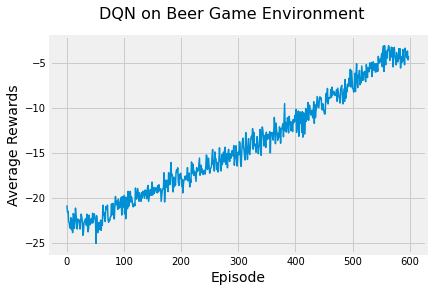

In [ ]:
#Start env
env = BeerGameEnv(max_inventory = 15, max_order = 6, avg_customer_demand = 4, demand_random = True, random_init=True)print_states_actions(env)


episode = 1
total_timesteps = 0
rewards_list = []


# Create Agent
DQA = DQAgent(len(env.action_space),
              network_input_shape=(4),
              replay_memory_size=EXPERIENCE_REPLAY_SIZE,
              minibatch_size=MINIBATCH_SIZE,
              learning_rate=LEARNING_RATE,
              discount_factor=DISCOUNT_FACTOR,
              dropout_prob=DROPOUT_PROB,
              epsilon=INITIAL_EPSILON,
              epsilon_decrease_rate=EPSILON_DECREASE_RATE,
              min_epsilon=MIN_EPSILON)




# Main loop
while episode < MAX_EPISODES:
    # Start episode

    print('-------------------------------------------------')
    print('Episode: ' + str(episode))
    sum_rewards = 0
    
    # Initialize first state
    current_state = env.reset()
    
    # Main episode loop
    t = 0
    total_timesteps += 1
    while t < MAX_TIMESTEPS_PER_EPISODE:

        
        # Select an action using the DQA
        action = DQA.get_action(np.asarray([current_state]))

        # Observe reward and next state
        (next_state, reward, done) = env.step(action)
        total_timesteps += 1

        # Store transition in replay memory
        DQA.add_experience(np.asarray([current_state]),
                           action,
                           reward,
                           np.asarray([next_state]),
                           done)
        
        # Train the agent
        if len(DQA.experience_replay) >= EXPERIENCE_START_SIZE:
            DQA.train()
            # Every C DQN updates, update DQN_target
            if DQA.training_count % TARGET_NETWORK_UPDATE_FREQ == 0 and DQA.training_count >= TARGET_NETWORK_UPDATE_FREQ:
                DQA.sync_target_network()
        
        # Linear epsilon annealing
        if len(DQA.experience_replay) >= EXPERIENCE_START_SIZE:
            DQA.update_epsilon()

        # Update the current state and score
        current_state = next_state
        sum_rewards += reward

        # Check end of episode
        if done:
            rewards_list.append(sum_rewards)
            print("Length: %d; Sum Rewards: %d" % (t + 1, sum_rewards))
            print("Epsilon = " + str(DQA.epsilon))
            print("Total Timesteps = " + str(total_timesteps))
            break
        
        # Increment Episode Timestep
        t += 1
    

    # Increment Episode counter
    episode += 1

plot_avg_rewards(np.array(rewards_list)/180, "DQN")   